# Predicción de supervivéncia del Titanic

Esta práctica se divide en dos partes:
1. En la primera parte entrenaremos un conjunto de modelos de clasificación de machine learning (perceptron, regression logística y arbol de decisión) para predecir la probabilidad que tendría un pasajero del Titánic de sobrevivir.
2. En la segunda parte realizaremos el *feature importance*, que básicamente consiste en analizar la importancia que tiene cada característica en cada uno de los modelos predictivos

![OHE](https://imgs.search.brave.com/CBGLwVZlwIgvFy4Xz8Bwqvb_lfMRFR3EcowdsdJxKU4/rs:fit:1200:675:1/g:ce/aHR0cHM6Ly93d3cu/Y29uY2llcnRvLmNs/L3dwLWNvbnRlbnQv/dXBsb2Fkcy8yMDIx/LzA0L1RpdGFuaWMu/anBn)


## Parte 1

### 1.1 Importar librerias
Importamos la librerias que usaremos

In [48]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import statistics

### 1.2 Cargamos el dataset
Cargamos el dataset para poder visualizar los datos que usaremos.

In [49]:
df = pd.read_csv("./dades.csv")

Para poder ver todas las columnas usamos la sigüiente instrucción de *pandas*

In [50]:
pd.set_option('display.max_columns',None)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.3 Limpieza de datos
Para poder entrenar a nuestros modelos previamente debemos "*masticar*" los datos

#### 1.3.1 Eliminar columnas (Ruido)
Lo primero que haremos será eliminar las columnas que contienen variables que no afectarán a nuestra predicción como el Id, el nombre del pasajero o el identificador del ticket

In [51]:
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Ticket', axis=1)

In [5]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


#### 1.3.2 Gestion de valores Nan
Ahora vamos a mostrar la cantidad de valores que hay en cada columna

In [52]:
df.count()

Survived    891
Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Cabin       204
Embarked    889
dtype: int64

El número de filas es 891 y las variables que no alcanzan ese valor nos muestran la cantidad de valores nulos que contienen

La característica 'Cabin', que hace referencia al identificador de la cabina donde se hospedaba el cliente, contiene una gran cantidad de valores Nan

In [53]:
(df['Cabin'].isna().sum()/891)*100 #Porcentaje de valores Nan

77.10437710437711

Estos valores Nan representan que el pasajero no tenia cabina. No podemos especular sobre si esto afecta o no a la predicció de su supervivencia, por tanto, también podriamos eliminar la columna. 
Primero dividiremos la columna en un valor binario para identificar si tenía columna o no. 
Más adelante evaluaremos si esta era la mejor opción cuando entrenoms el modelo.

In [54]:
def set_bin(cabin:str):
    if cabin != cabin:
        return 0
    else:
        return 1
    
df['Cabin'] = [set_bin(x) for x in df['Cabin']]

Otra cantidad un poco más pequeña de falta de valores se encuentra en la columna '*Age*', la cual podemos completar con la media de todos los pasajeros

In [55]:
df['Age'].fillna(df['Age'].median(), inplace = True)

Por último nos faltaria gestionar la columna '*Embarked*'. Los valores nulos de esta característica también los podriamos completar con la media si no fuera porque no son un valor numérico. Debido a esto, usaremos otro estadístico que es la moda. Este estadísctico reflejará el valor que mas se repite dentro de la muestra

In [56]:
df['Embarked'].fillna(df['Embarked'].mode(), inplace = True)

#### 1.3.3 Valores categóricos
Dentro de este dataset econtramos características como el sexo que son incompatibles con el aprendizaje de los modelos predictivos. Para ello debemos conseguir que todas la columnas de nuestro conjunto de datos contengan valores numéricos.
Para solucionar esto usaremos la técnica de **One hot encoding** que consiste en ampliar el número de columnas según los posibles valores y rellenarlas con un valor binario.
![OHE](https://www.statology.org/wp-content/uploads/2021/09/oneHot1.png)

Realizaremos esto con las columnas '*Sex*', '*Embarked*' y '*Pclass*'

In [57]:
#Para el sexo
clb = df.pop("Sex")
ohe_clb = pd.get_dummies(clb, prefix='sexo')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

In [58]:
#Para el Embarque
clb = df.pop("Embarked")
ohe_clb = pd.get_dummies(clb, prefix='embarque')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

In [59]:
#Para el Embarque
clb = df.pop("Pclass")
ohe_clb = pd.get_dummies(clb, prefix='Clase')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

df.head()

,Survived,Age,SibSp,Parch,Fare,Cabin,sexo_female,sexo_male,embarque_C,embarque_Q,embarque_S,Clase_1,Clase_2,Clase_3
0,0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,1


Ahora debemos pasar todos los valores de las columnas a el mismo tipo de dato. En este caso haremos que todos sean floats de 64 bits para mantener los decimales en '*Age*' y '*Fare*'.

In [60]:
for column in df:
    df[column]=df[column].astype(float)

#### 1.3.4 Normalización
Para mantener los mismos rangos entre los valores de las columnas procedemos a normalizar. Esta operación la aplicaremos sobre las características '*Age*' y '*Fare*'

In [61]:
scaler = StandardScaler()
df.Age=scaler.fit_transform(df.Age.values.reshape(-1,1))
df.Fare=scaler.fit_transform(df.Fare.values.reshape(-1,1))
df.SibSp=scaler.fit_transform(df.SibSp.values.reshape(-1,1))
df.Parch=scaler.fit_transform(df.Parch.values.reshape(-1,1)) 
df.head()

,Survived,Age,SibSp,Parch,Fare,Cabin,sexo_female,sexo_male,embarque_C,embarque_Q,embarque_S,Clase_1,Clase_2,Clase_3
0,0.0,-0.565736,0.432793,-0.473674,-0.502445,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.663861,0.432793,-0.473674,0.786845,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,-0.258337,-0.474545,-0.473674,-0.488854,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.433312,0.432793,-0.473674,0.420730,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.433312,-0.474545,-0.473674,-0.486337,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


#### 1.3.5 Analisis Exploratorio de los Datos (EDA)
Ahora mostramos la matriz de correlación para intentar entcontrar valores dependientes o redundantes

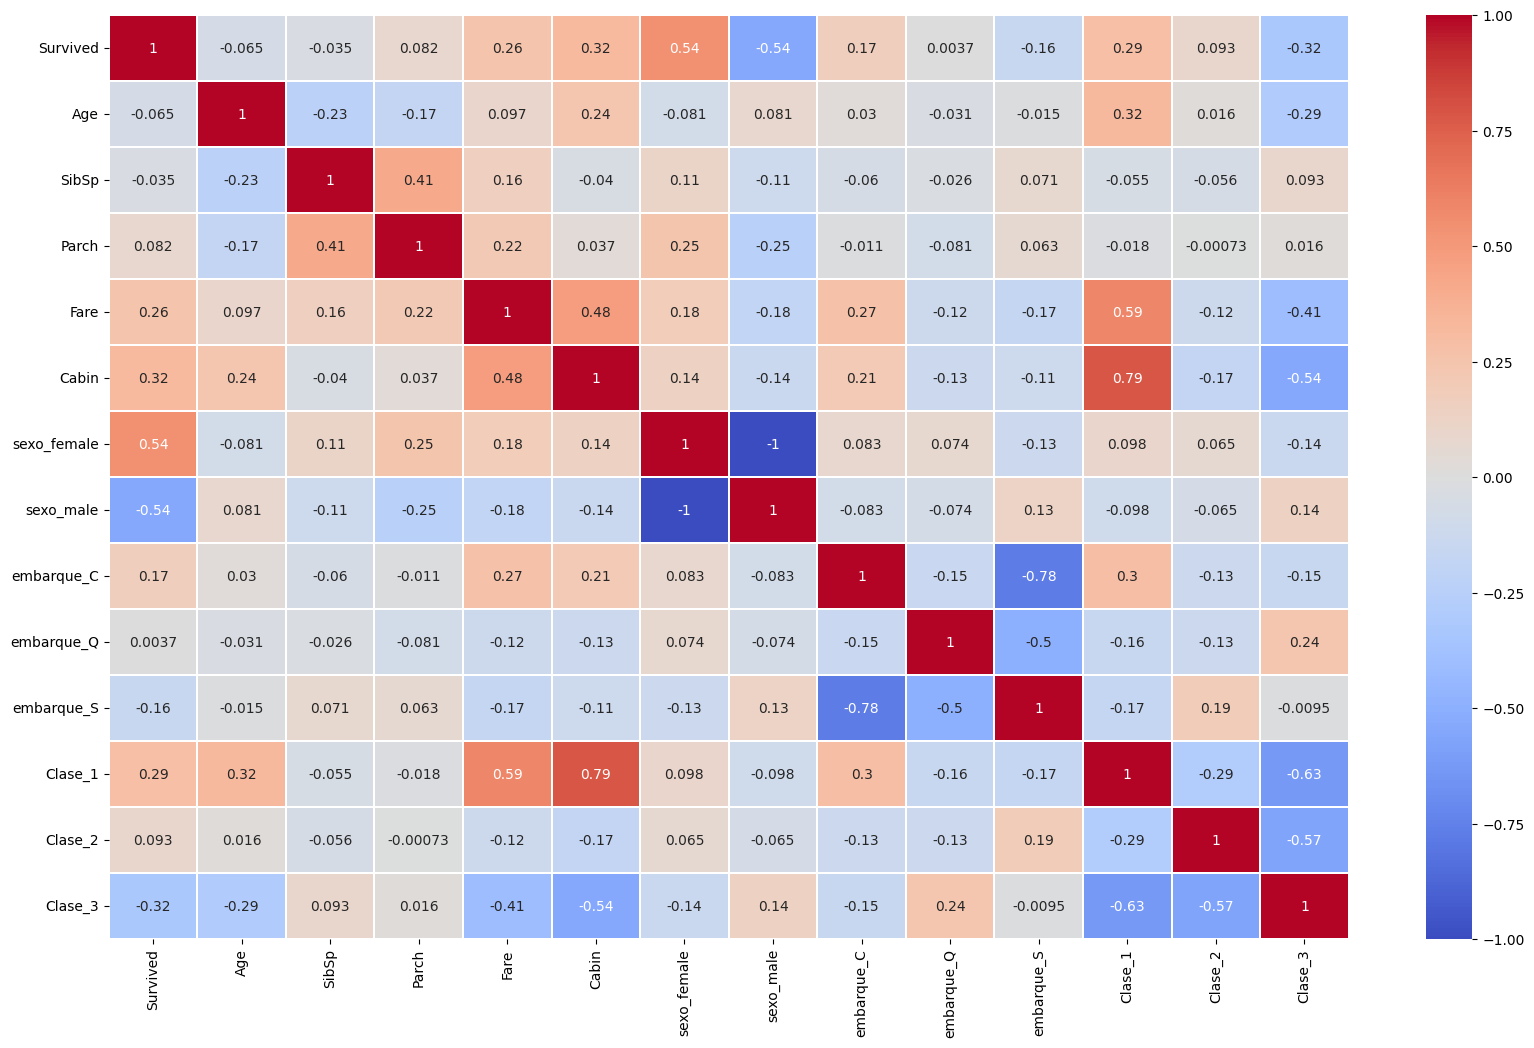

In [19]:
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

Al analizar la matriz podemos observar que hay una serie de valores relacionados con la columna '*Survived*' que destacan sobre otros, es decir, que estan mas cerca de 1 o -1. Para analizar estos valores hay que saber que si una casilla toma un valor positivo entonces los valores de las dos columnas relacionadas incrementan cuando el otro incrementa. En cambio si es negativo, cuando uno sube el otro baja.

Por ejemplo, los valores mas representativos son los que relacionan '*sexo_female*' y '*sexo_male*' con 'survived'. En el primer caso el valor de la intersección es +0.54, lo que significa que, al ser positivo, si aumenta el valor de 'sexo_female' aumenta también el de '*Survived*'. Y en el segundo caso, el valor es -0.54 que al ser negativo significa que el aumentar el valor de '*sexo_male*' disminuye el valor de 'survived'. Después de analizar estos dos primeros ejemplos podemos llegar a una conclusión de que el sexo femenino tiene más posibilidades de sobrevivir que el masculino, ya que en la matriz de correlación tiene un valor positivo elevado.

Otra columna interesante es la de '*Pclass*' con un valor de -0.34 lo que nos indica que cuanto mayor sea la clase menos probabilidades de sobrevivir. En el Titanic había tres clases (1,2 y 3) por lo que los de clase 1 tenían más posibilidades de sobrevivir que los de clase 2 o 3.

Por último hay que destacar la columna '*Fare*' que tiene un valor de 0.26 (cuanto más vale fare, más vale survived). En nuestro dataset el valor '*Fare*' indica la cantidad que han pagado las personas por el billete, por lo que los que más han pagado tiene más posibilades de sobrevivir que los que han pagado una cantidad menor.

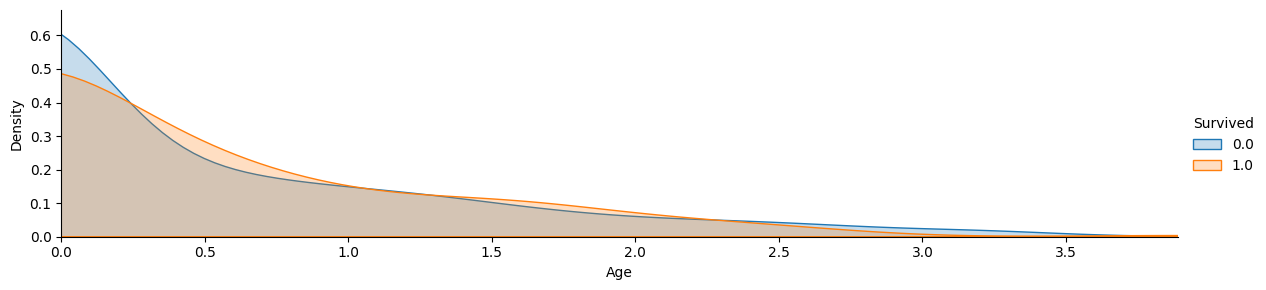

In [20]:
facet = sns.FacetGrid(df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',fill=True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend() 
plt.show()

Como podemos observar en el gráfico anterior entre el rango de edad de 18-40 años nos encontramos con más cantidad de personas que en los otros rangos, por lo que es normal que muera y sobrevive más gente, aunque se puede ver como en este rango de edad hay más densidad de personas que no sobreviven a que sobreviven. Además, en el rango de edad de 0 a 18 años nos encontramos con que hay más supervivientes, y que a partir de los 45 años se igualan los supervivientos con los no supervivientes superando estos últimos a los primeros una vez superados los 60.

Con estos podemos sacar la conclusión que la edad era un factor importante si eras menor de edad ya que los niños eran prioritarios para salvarse, pero que a medida que aumentan los años las opciones de sobrevivir disminuyen.

(0.0, 20.0)

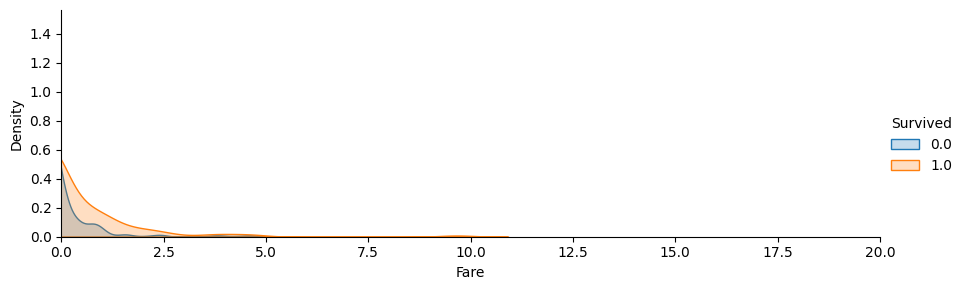

In [22]:
facet = sns.FacetGrid(df, hue="Survived",aspect=3)
facet.map(sns.kdeplot,'Fare',fill=True)
facet.set(xlim=(0, df['Fare'].max()))
facet.add_legend() 
plt.xlim(0,20)

También hemos realizado un gráfico para ver si el precio que han pagado los pasajeros influye en las opciones de sobrevivir. Claramente se puede decir que si que influye ya que vemos que donde hay más densidad de muertes es al principio del eje x, lo que significa que los que menos pagaron tuvieron menos posibilidades de sobrevivir. Y a medida que el eje x aumenta nos encontramos con más supervivientes.

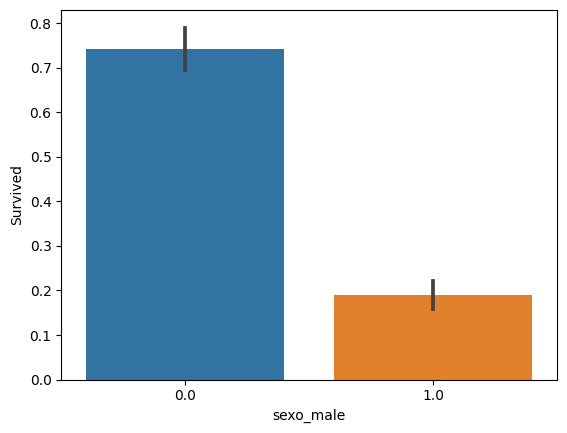

In [23]:
sns.barplot(x = "sexo_male", y = "Survived", data = df)
plt.show()

Este gráfico representa la media (entre 0 y 1) de supervivientes según el sexo. El color azul representa el sexo femenino y el naranja el masculino. A primera vista podemos observar como hay muchas más mujeres que sobreviven por encima de los hombres lo que nos lleva a la conclusión que tenían prioridad respecto al género masculino y por lo tanto había más posibilidades de no morir siendo mujer.

### 1.4 Modelos
Ahora procedemos a crear y entrenar los distintos modelos con los datos anteriormente revisados, para así evaluar su precisión. 
Importamos las librerias necesarias

In [62]:
#Dividir datos para evitar overfitting y poder evaluar
from sklearn.model_selection import train_test_split 
#Precisión
from sklearn.metrics import accuracy_score
#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Dividimos los datos entre entrenamiento y evaluación, habiendo separado previamente el objetivo que queremos predecir, en este caso '*Survived*'

In [63]:
X_data = df.drop("Survived",axis=1)
Objetivo = df["Survived"]
X_train,X_test,y_train,y_test = train_test_split(X_data,Objetivo,test_size=0.33,random_state=42)

Preparamos otro conjunto de datos pero sin contener la columna '*Cabin*' para comprobar que forma de entrenar los modelos es más óptima

In [64]:
X_data = df.drop("Survived",axis=1)
X_data2 = X_data.drop("Cabin",axis=1)
Objetivo = df["Survived"]
X_train2,X_test2,y_train2,y_test2 = train_test_split(X_data2,Objetivo,test_size=0.33,random_state=42)

#### 1.4.1 Regresión Logística
Este método estadístico trata de modelar la probabilidad de una variable cualitativa binaria, en este caso '*Survived*', en función de una o más variables como las que tenemos en el dataset.
Esta modelo sigue una función sigmoide:
![OHE](https://wikimedia.org/api/rest_v1/media/math/render/svg/9f9655dad99527a46d3d532543360135b492dfd2)  

Esta función es continua y derivable. En este caso, no la podemos observar gráficamente puesto que el numero de dimensiones no es observable.
Con la libreria sklearn podemos crear este modelo y reducir el error de su '*loss function*' o lo que se conoce como entrenamiento. 

Creamos el modelo y lo entrenamos

In [65]:
modeloLR = LogisticRegression()
modeloLR.fit(X_train,y_train)
prediction_lr=modeloLR.predict(X_test)
print('La precisión del modelo de Regresión Logística es del ',
      round(accuracy_score(prediction_lr,y_test)*100,2),'%')

La precisión del modelo de Regresión Logística es del  82.03 %


Entrenamos el otro modelo sin la columna '*Cabin*'

In [66]:
modeloLR2 = LogisticRegression()
modeloLR2.fit(X_train2,y_train2)
prediction_lr2=modeloLR2.predict(X_test2)
print('La precisión del modelo de Regresión Logística es del',
      round(accuracy_score(prediction_lr2,y_test2)*100,2),'%')

La precisión del modelo de Regresión Logística es del 81.02 %


Como se puede comprobar, la precisión del modelo entrenado con la columna '*Cabin*', es considerablemente superior

Una vez hemos decidido el conjunto de datos con el que entrenaremos los modelos debemos optimizar los parametros de los predictores para que sean los más óptimos posible.
Esto se puede realizar haciendo uso de la libreria **GridSearchCV**

In [67]:
#PARAMETROS
#numero de iteraciones
iteraciones = np.array([700,800,850,900,1000,1100,1200])
#Algoritmo usado en la optimización
optimizadores = np.array(['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'])

grid=GridSearchCV(estimator = modeloLR,
                  param_grid = dict(max_iter = iteraciones,
                                   solver = optimizadores
                                   ),
                  cv = 3)
grid.fit(X_train,y_train)
#Mejores parametros para usar
print(grid.best_params_)

{'max_iter': 700, 'solver': 'lbfgs'}


Una vez que optimizamos los parámetros posibles (a pesar de que la libreria cuente con más posiblilidades nosotros contemplamos estos) pasamos a crear el modelo de regresión logística definitivo.

In [68]:
new_modeloLR = LogisticRegression(max_iter=700, solver='lbfgs')
new_modeloLR.fit(X_train,y_train)
new_prediction_lr=new_modeloLR.predict(X_test)
print('La precisión del modelo de Regresión Logística es del ',
      round(accuracy_score(new_prediction_lr,y_test)*100,2),'%')

La precisión del modelo de Regresión Logística es del  82.03 %


#### 1.4.2 Perceptron
Un perceptrón es un modelo matemático inspirado en una estructura y función simplificadas de una única neurona biológica. 
Los valores de entrada múltiples alimentan el modelo del perceptrón, el modelo se ejecuta con los valores de entrada, y si el valor estimado es el mismo que la salida requerida, entonces el rendimiento del modelo se encuentra satisfecho, por lo que los pesos no exigen cambios. De hecho, si el modelo no cumple con el resultado requerido, entonces se realizan algunos cambios en los pesos para minimizar los errores, así hasta converger un una zona con un mínimo error.

![OHE](https://imgs.search.brave.com/5JQsB-RHZyxiVSzvuvb83kMMZ4APv1-LbMeA3SJCdI4/rs:fit:629:302:1/g:ce/aHR0cHM6Ly9hbGV4/YW5kZXJoYXkyMDIw/LmdpdGh1Yi5pby9h/c3NldHMvaW1nL25u/XzAyLnBuZw)

Como anteriormente hemos visto que la columna '*Cabin*' si que aumenta el rendimiento, la usaremos para entrenar el resto de nuestros modelos de predicción. 
Vovemos a consultar los mejores parametros para el modelo 

In [69]:
#PARAMETROS
#numero de iteraciones
iteraciones = np.array([700,800,850,900,1000,1100,1200])
#Constante para regularizar 
alphas = np.array([1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01])
#Mezclar o no después de cada ciclo
mezcla = [True, False]

grid=GridSearchCV(estimator = Perceptron(),
                  param_grid = dict(max_iter = iteraciones,
                                   alpha = alphas,
                                   shuffle = mezcla),
                  cv = 3)
grid.fit(X_train,y_train)
#Mejores parametros para usar
print(grid.best_params_)

{'alpha': 1.0, 'max_iter': 700, 'shuffle': True}


Ahora cogemos estos parametros para entrenar el modelo

In [70]:
modeloPer = Perceptron(alpha=1.0,max_iter=700,shuffle=True)
modeloPer.fit(X_train,y_train)
prediction_per=modeloPer.predict(X_test)
print('La precisión del Perceptron es del ',
      round(accuracy_score(prediction_lr,y_test)*100,2),'%')

La precisión del Perceptron es del  82.03 %


#### 1.4.3 Clasificador de Árbol de Decision
Como su nombre indica, esta técnica de machine learning toma una serie de decisiones en forma de árbol. Los nodos intermedios (las ramas) representan soluciones. Los nodos finales (las hojas) nos dan la predicción que vamos buscando.
decision

En cada nodo del árbol se debe tomar una decisión entre un valor atribuido a dicho nodo. Para asignar los atributos de decisión más predecibles a los nodos se usa la entropia, que representa la homogeneidad de las muestras en ese nodo

Una vez decidios los parametros de los nodos ya está formado el modelo que decide:
![OHE](https://imgs.search.brave.com/8PTRz3Dd3BnAKnDBaItdO9JaqsOSOJ0Icte7UpTAka4/rs:fit:663:528:1/g:ce/aHR0cHM6Ly9taXJv/Lm1lZGl1bS5jb20v/bWF4LzEzMjYvMSp4/R3NZYzZhWGVoRDds/eW9MRW4tbU1BLnBu/Zw)
Para problemas más complejos se puede utilizar el '**Random Forest Classifier**', que en pocas palabras, utiliza varios arboles de decisión, de ahí el nombre *forest*.

Como hemos visto antes, estos modelos necesitan de unos atributos para poder predecir. Estos atributos los inicializan a través de diferentes criterios, que són *gini, entropy y log_loss*, que hacen referencia a:

-La impureza de Gini (desigualdad): $H(Q_m) = \sum_k p_{mk} (1 - p_{mk})$ 

-La ganancia de información: $H(Q_m) = - \sum_k p_{mk} \log(p_{mk})$ 

respectivamente.

Para ver que modelo y criterio es mejor entrenaremos cada uno de ellos con los mejores criterios para evaluar su rendimiento.

Creamos un dataset para comparar sus rendimientos

In [71]:
#PARAMETROS NECESARIOS
#criterio para predecir atributo
criterios = np.array(['gini','entropy','log_loss'])
#estrategia para separar en cada nodo
separa = np.array(['best', 'random'])
#numero de arboles en el bosque
trees = np.arange(20,120,10)
#El minimo de numero de muestras para dividir un nodo interno
divide = np.arange(2,8,1)
#El minimi numero de muestras para ser un nodo hoja
hoja = np.arange(1,9,1)

#Mejores parametros para el arbol de decisión
gridDT=GridSearchCV(estimator = DecisionTreeClassifier(),
                  param_grid = dict(criterion=criterios,
                                   splitter=separa,
                                   min_samples_split=divide,
                                   min_samples_leaf=hoja),
                  cv = 3)
gridDT.fit(X_train,y_train)
#Mejores parametros para usar
print('Parámetros para el Árbol de Decisión són:',gridDT.best_params_)

#Mejores parametros para el RandomForest
gridRF=GridSearchCV(estimator = RandomForestClassifier(),
                  param_grid = dict(criterion=criterios,
                                   n_estimators=trees),
                  cv = 3)
gridRF.fit(X_train,y_train)
#Mejores parametros para usar
print('Parámetros para el Random Forest són:',gridRF.best_params_)

Parámetros para el Árbol de Decisión són: {'criterion': 'entropy', 'min_samples_leaf': 6, 'min_samples_split': 3, 'splitter': 'random'}
Parámetros para el Random Forest són: {'criterion': 'entropy', 'n_estimators': 80}


Como hemos visto no hemos puesto todos los paramtros para optimizar porque el tiempo de ejecución sería muy elevado

Ahora entrenamos los dos modelos con sus parametros óptimos y comparamos sus rendimientos.


Árbol de Decisión

In [72]:
modeloArbol= DecisionTreeClassifier(criterion='entropy', min_samples_split=4, 
                                    min_samples_leaf=8, max_features='sqrt')
modeloArbol.fit(X_train,y_train)
prediction_tree=modeloArbol.predict(X_test)
print('La precisión del Árbol de Decisión es del ',
      round(accuracy_score(prediction_tree,y_test)*100,2),'%')

La precisión del Árbol de Decisión es del  77.63 %


Random Forest

In [73]:
modeloBosque= RandomForestClassifier(criterion='gini', n_estimators=60, max_features='sqrt')
modeloBosque.fit(X_train,y_train)
prediction_forest=modeloBosque.predict(X_test)
print('La precisión del Random Forest es del ',
      round(accuracy_score(prediction_forest,y_test)*100,2),'%')

La precisión del Random Forest es del  76.95 %


Como podemos comprobar el rendimiento de ambos es muy parecido, siendo prácticamente irrelevante la decisión de escoger uno frente a otro.

Otra cosa a destacar es el hecho a que debido a impedimentos de las versiones de las librerias hemos tenido que seleccionar el parámetro 'max_features' en 'sqrt'. Este parámetro únicamente hace referencia al el número de muestras máximo para considerar un split en el nodo.

## Parte 2

Esta segunda parte consiste en obtener la importáncia de cada característica para cada uno de los modelos, lo que se conoce como '*feature importance*'

Los modelos asignan pesos, $w_i$, a los parámetros , $x_i$, para poder obtener su predicción. 

Para realizar esta parte, primero debemos obtener los pesos de cada uno de los parametros para todos los modelos

In [74]:
#Creamos data set para ordenar
df1=pd.DataFrame(columns=df.columns)
df1=df1.drop('Survived',axis=1)

Debido a la naturaleza estocástica de los algoritmos, estos pesos pueden variar. Es por eso que añadiremos al dataset la media de cada uno de ellos. Para poder hacer esto crearemos una función que nos devuelva la media de los pesos después de un número de iteraciones, según el modelo que le pasemos por parámetro

In [75]:
def get_weights(modelo, num_iter):
    weights = []
    #Para cada columna sacamos su peso
    for i,caract in enumerate(df1.columns):
        aux = []
        for j in range(num_iter):
            #en cada iteración sacamos de nuevo los pesos
            w = modelo.coef_.tolist()
            aux.append(w[0][i-1])
        #calculamos la media
        weights.append(sum(aux)/len(aux))
        
    return weights

Cabe mencionar que para poder realizar esta comparación de importancia de las características según los pesos del modelo necesitamos que las columnas de los datos de aprendizaje estén normalizados, es decir, han de estar en la misma escala. Es por eso que hemos realizado ese paso en la **Parte 1**

### 2.1 Regresión Logística

Obtenemos los valores medios y los añadimos a el dataset 

In [76]:
pesos = []
keys =  df1.columns
iterations = 10

pesos = get_weights(new_modeloLR, iterations)
dictionary = dict(zip(keys, pesos))

dflr = pd.DataFrame(dictionary, index=['Pesos Regresión Logística'])
#añadimos al dataset
df1 = pd.concat([df1, dflr], axis=0)
df1.head()

,Age,SibSp,Parch,Fare,Cabin,sexo_female,sexo_male,embarque_C,embarque_Q,embarque_S,Clase_1,Clase_2,Clase_3
Pesos Regresión Logística,-0.605381,-0.320364,-0.274319,-0.113034,0.205499,1.193323,1.248586,-1.248599,0.356689,0.015567,-0.449766,-0.051315,0.656683


### 2.2 Perceptron

Obtenemos los valores medios y los añadimos al dataset

In [77]:
pesos = []
keys =  df1.columns
iterations = 10

pesos = get_weights(modeloPer, iterations)
dictionary = dict(zip(keys, pesos))

dflr = pd.DataFrame(dictionary, index=['Pesos Perceptron'])
#añadimos al dataset
df1 = pd.concat([df1, dflr], axis=0)
df1.head()

,Age,SibSp,Parch,Fare,Cabin,sexo_female,sexo_male,embarque_C,embarque_Q,embarque_S,Clase_1,Clase_2,Clase_3
Pesos Regresión Logística,-0.605381,-0.320364,-0.274319,-0.113034,0.205499,1.193323,1.248586,-1.248599,0.356689,0.015567,-0.449766,-0.051315,0.656683
Pesos Perceptron,-4.000000,1.297347,-3.154809,-2.008933,1.552070,3.000000,3.000000,-4.000000,1.000000,0.000000,-2.000000,0.000000,3.000000


### 2.3 Clasificador de arbol
Obtenemos los valores medios y los añadimos al dataset. Para hacer esto usaremos únicamente el **RandomForestClassifier** ya que es ligéramente superior al **DecisionTreeClassifier**

Como el **RandomForestClassifier** no tiene el atributo .coef__, debemos crear otra función para obtener los pesos. Para ello utilizaremos el atributo `*feature_importances_*'.

In [78]:
pesos = []
keys =  df1.columns
iterations = 10

pesos = modeloBosque.feature_importances_

dictionary = dict(zip(keys, pesos))

dflr = pd.DataFrame(dictionary, index=['Pesos RandomForest'])
#añadimos al dataset
df1 = pd.concat([df1, dflr], axis=0)
df1.head()

,Age,SibSp,Parch,Fare,Cabin,sexo_female,sexo_male,embarque_C,embarque_Q,embarque_S,Clase_1,Clase_2,Clase_3
Pesos Regresión Logística,-0.605381,-0.320364,-0.274319,-0.113034,0.205499,1.193323,1.248586,-1.248599,0.356689,0.015567,-0.449766,-0.051315,0.656683
Pesos Perceptron,-4.000000,1.297347,-3.154809,-2.008933,1.552070,3.000000,3.000000,-4.000000,1.000000,0.000000,-2.000000,0.000000,3.000000
Pesos RandomForest,0.238654,0.042554,0.036044,0.241146,0.040041,0.128645,0.136641,0.016789,0.008837,0.019563,0.016467,0.024223,0.050396


### 2.4 Analisis, evaluación y explicación
